In [1]:
# imports
from qaoa_application import apply_qaoa_statevector
from qaoa_mincost_k_sat import problem_circuit as puso_problem_circuit, convert_ancilla_bit_results
from qaoa_mincost_sat import problem_circuit as quso_problem_circuit
from configproblem.util.hamiltonian_math import get_hamiltonian_dimension
from configproblem.util.visualization import plot_counts_histogram, plot_beta_gamma_cost_landscape, plot_f_mu_cost_landscape
from configproblem.util.problem_instance import ProblemInstance, generate_problem_instance_set
from pprint import pprint
import numpy as np
from qubovert import boolean_var

In [2]:
# instance generation config
use_predefined_instances = False

num_instances = 10
num_features = 6
min_num_clauses = 2
max_num_clauses = 3
min_num_literals_per_clause = 3
max_num_literals_per_clause = 3
min_feature_cost = 0
max_feature_cost = 0
alpha_sat = None
seed = 42
generation_type = 'alpha_sat' # 'random', 'growing_num_clauses', 'growing_num_literals', 'growing_num_clauses_and_literals, 'append_clauses' or 'alpha_sat'
# instance used as starting point for generation type 'alpha_sat', set to None to use randomly generated instance
x1, x2, x3, x4, x5, x6 = boolean_var('x1'), boolean_var('x2'), boolean_var('x3'), boolean_var('x4'), boolean_var('x5'), boolean_var('x6')
start_instance = ProblemInstance([[(x1, True), (x2, True)],
                                  [(x3, False), (x4, False)],
                                  [(x3, True), (x4, True)],
                                  [(x5, False), (x6, True)]],
                                 [x1, x2, x3, x4, x5, x6],
                                 [100, 100, 100, 100, 100, 10],
                                 alpha_sat=1000)


# run config
run_print_hamiltonians = False
run_cost_landscape = False
run_puso_qaoa = True
run_quso_qaoa = True


# cost landscape config
beta_gamma_step_size = 0.2

# qaoa application config
layers = 60 # more layers = higher approximation rate but more quantum errors when running on real qpu
theta = {"beta": 0.01, "gamma": -0.01} # start values for optimization
strategy = 'min'
use_warmstart = False
use_optimizer = True
print_res = False
warmstart_statevector = None

In [3]:
if not use_predefined_instances:
    problem_instances = generate_problem_instance_set(num_instances, num_features, min_num_clauses, max_num_clauses, min_num_literals_per_clause, max_num_literals_per_clause, min_feature_cost, max_feature_cost, alpha_sat, seed=seed, generation_type=generation_type, start_instance=start_instance)
else:
    # define binary vars needed for problem instances
    x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = boolean_var('x1'), boolean_var('x2'), boolean_var('x3'), boolean_var('x4'), boolean_var('x5'), boolean_var('x6'), boolean_var('x7'), boolean_var('x8'), boolean_var('x9'), boolean_var('x10')

    # define set of problem instances to evaluate
    problem_instances = [ProblemInstance([[(x1, True), (x2, True)],
                                          [(x2, True), (x3, False), (x4, True)],
                                          [(x3, True), (x5, False), (x6, False)]],
                                         [x1, x2, x3, x4, x5, x6],
                                         [10, 10, 10, 10, 10, 10],
                                         alpha_sat=1000),
                         # more variables
                         ProblemInstance([[(x1, True), (x2, True), (x7, False)],
                                          [(x2, True), (x3, False), (x4, True), (x8, False)],
                                          [(x3, True), (x5, False), (x6, False), (x9, True)]],
                                         [x1, x2, x3, x4, x5, x6, x7, x8, x9],
                                         [10, 10, 10, 10, 10, 10, 10, 10, 10],
                                         alpha_sat=1000),
                         # more literals per clause
                         ProblemInstance([[(x1, True), (x2, True), (x3, False)],
                                          [(x2, True), (x3, False), (x4, True), (x5, True)],
                                          [(x3, True), (x5, False), (x6, False), (x7, False)]],
                                         [x1, x2, x3, x4, x5, x6, x7],
                                         [10, 10, 10, 10, 10, 10, 10],
                                         alpha_sat=1000),
                         # more variables and move literals per clause
                         ProblemInstance([[(x1, True), (x2, True), (x7, False)],
                                          [(x2, True), (x3, False), (x4, True), (x8, False)],
                                          [(x3, True), (x5, False), (x6, False), (x9, True), (x10, False)]],
                                         [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10],
                                         [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
                                         alpha_sat=1000),
                         # less clauses
                         ProblemInstance([[(x1, True), (x2, True)],
                                          [(x2, True), (x3, False), (x4, True)]],
                                         [x1, x2, x3, x4],
                                         [10, 10, 10, 10],
                                         alpha_sat=1000),
                         ProblemInstance([[(x1, True), (x2, True)],
                                          [(x3, True), (x5, False), (x6, False)]],
                                         [x1, x2, x3, x4, x5, x6],
                                         [10, 10, 10, 10, 10, 10],
                                         alpha_sat=1000),
                         ProblemInstance([[(x2, True), (x3, False), (x4, True)],
                                          [(x3, True), (x5, False), (x6, False)]],
                                         [x1, x2, x3, x4, x5, x6],
                                         [10, 10, 10, 10, 10, 10],
                                         alpha_sat=1000),
                         # more clauses
                         ProblemInstance([[(x1, True), (x2, True)],
                                          [(x2, True), (x3, False), (x4, True)],
                                          [(x3, True), (x5, False), (x6, False)],
                                          [(x4, True), (x6, True)]],
                                         [x1, x2, x3, x4, x5, x6],
                                         [10, 10, 10, 10, 10, 10],
                                         alpha_sat=1000),
                         # even more clauses
                         ProblemInstance([[(x1, True), (x2, True)],
                                          [(x2, True), (x3, False), (x4, True)],
                                          [(x3, True), (x5, False), (x6, False)],
                                          [(x4, True), (x6, True)],
                                          [(x1, False), (x4, False), (x5, True)]],
                                         [x1, x2, x3, x4, x5, x6],
                                         [10, 10, 10, 10, 10, 10],
                                         alpha_sat=1000)]

In [4]:
# print hamiltonians
for index, instance in enumerate(problem_instances):
    if run_print_hamiltonians:
        print(f"Instance {index}:")
        pprint(instance.get_puso_combined_hamiltonian())

In [5]:
# plot cost landscape
if run_cost_landscape:
    for index, instance in enumerate(problem_instances):
        print(f"Instance {index}:")
        hamiltonians = [{'hamiltonian': instance.get_puso_sat_hamiltonian(), 'name': 'SAT'},
                        {'hamiltonian': instance.get_cost_hamiltonian(), 'name': 'COST'},
                        {'hamiltonian': instance.get_puso_combined_hamiltonian(), 'name': 'COMBINED'}]
        strategies = ['min', 'avg', 'top']
        plot_beta_gamma_cost_landscape(quso_problem_circuit, hamiltonians, strategies, instance.get_num_features(), beta_gamma_step_size)
        plot_f_mu_cost_landscape(instance.get_puso_combined_hamiltonian(), instance.get_num_features())

Instance 0:


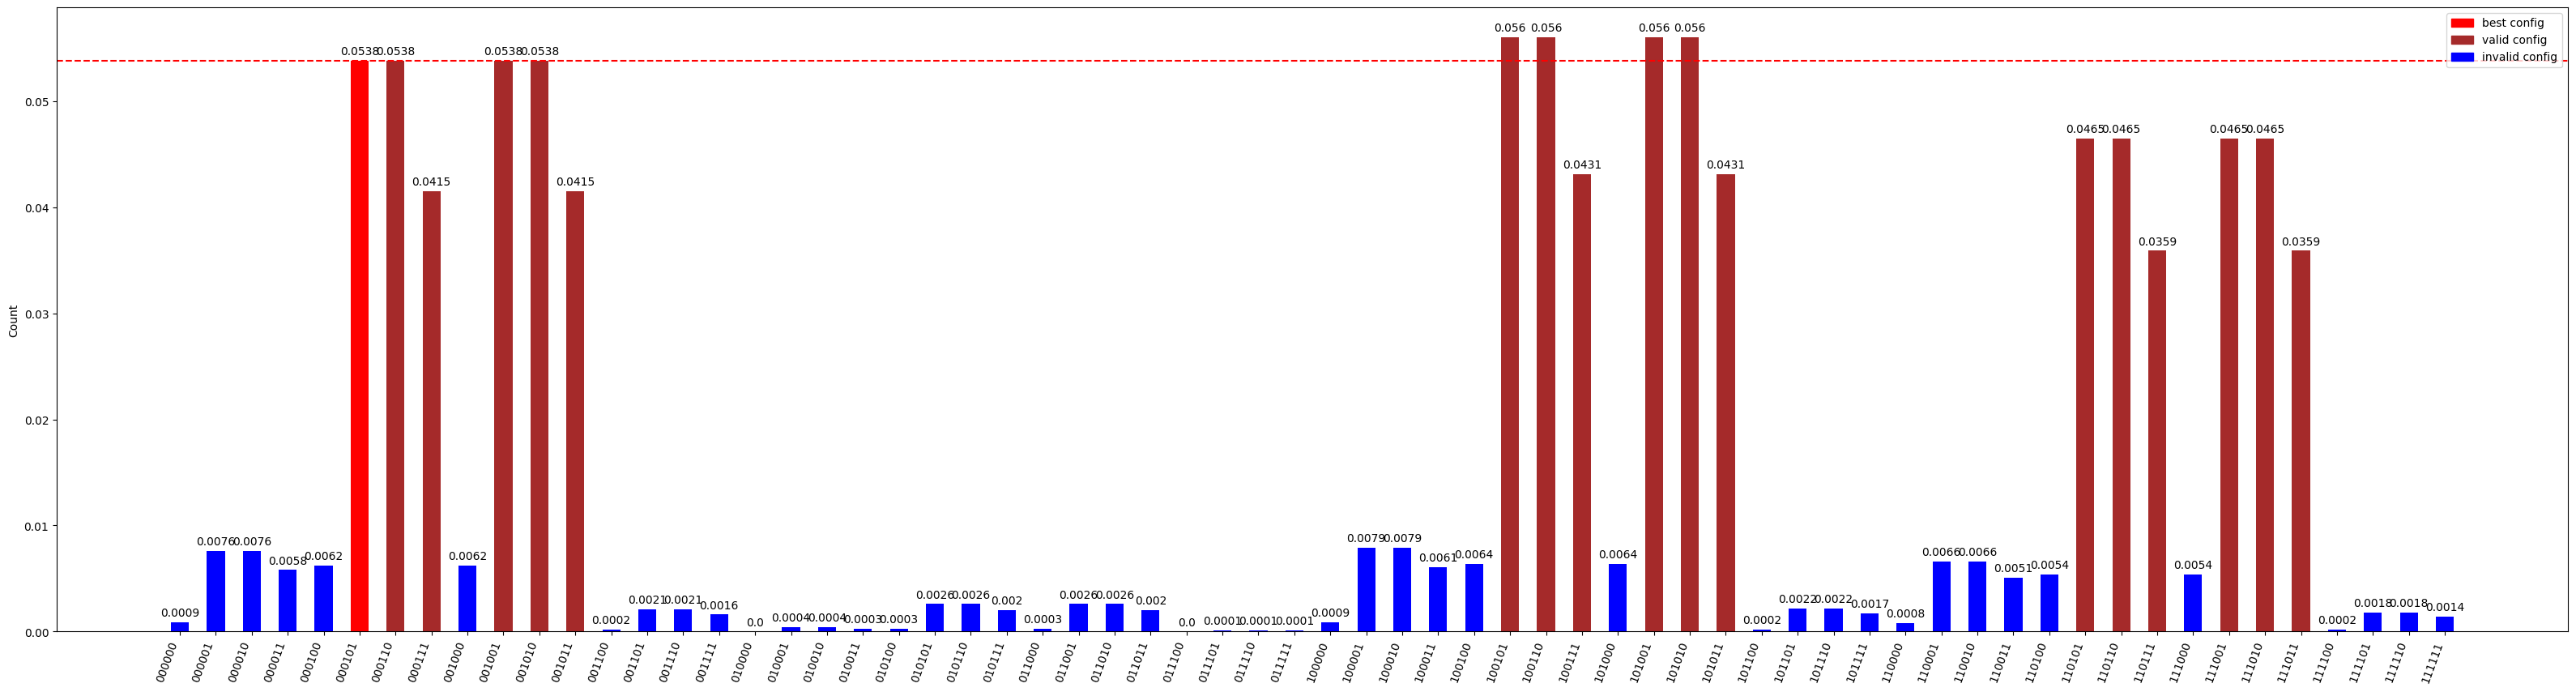

In [6]:
# plot PUBO results
probabilities_list = []
if run_puso_qaoa:
    for index, instance in enumerate(problem_instances):
        print(f"Instance {index}:")
        hamiltonian = instance.get_puso_combined_hamiltonian()

        probabilities, _ = apply_qaoa_statevector(puso_problem_circuit, hamiltonian, layers, get_hamiltonian_dimension(hamiltonian), theta, warmstart_statevector, strategy=strategy, use_optimizer=use_optimizer, print_res=print_res)
        probabilities_list.append(probabilities)
        probabilities_dict = {}
        for i in range(0, 2 ** get_hamiltonian_dimension(hamiltonian)):
            probabilities_dict[(np.binary_repr(i, width=get_hamiltonian_dimension(hamiltonian)))] = round(probabilities[i], 4)

        plot_counts_histogram(probabilities_dict, get_hamiltonian_dimension(hamiltonian), instance.get_best_config(), instance.get_valid_configs())

In [7]:
# rank instances by result_quality = success_probability * 2^num_features / num_valid_configs
if run_puso_qaoa:
    result_quality_list = []
    for index, instance in enumerate(problem_instances):
        if len(instance.get_valid_configs()) == 0:
            continue
        # determine result quality
        probabilities = probabilities_list[index]
        probabilities_dict = {}
        for i in range(0, 2 ** get_hamiltonian_dimension(instance.get_puso_combined_hamiltonian())):
            probabilities_dict[(np.binary_repr(i, width=get_hamiltonian_dimension(instance.get_puso_combined_hamiltonian())))] = probabilities[i]

        result_quality = 0
        for config in instance.get_valid_configs():
            result_quality += probabilities_dict[config]
        result_quality *= 2 ** instance.get_num_features() / len(instance.get_valid_configs())
        result_quality_list.append(result_quality)

    # sort instances by result_quality
    sorted_indices = np.argsort(result_quality_list)
    sorted_indices = sorted_indices[::-1]
    sorted_problem_instances = [problem_instances[i] for i in sorted_indices]
    success_probabilities_per_valid_config_list = [result_quality_list[i] for i in sorted_indices]
    for index, instance in enumerate(sorted_problem_instances):
        print(f"Instance {sorted_indices[index]}:")
        print(str(instance))
        print(f"Result quality: {result_quality_list[sorted_indices[index]]}\n")

Instance 0:
sat_instance: (\neg x1 \vee \neg x2) \wedge (x3 \vee x4) \wedge (\neg x3 \vee \neg x4) \wedge (x5 \vee \neg x6)
n_features: 6
feature_cost: [100, 100, 100, 100, 100, 10]
alpha_sat: 765.0
Result quality: 3.0804848638571225


Instance 0:


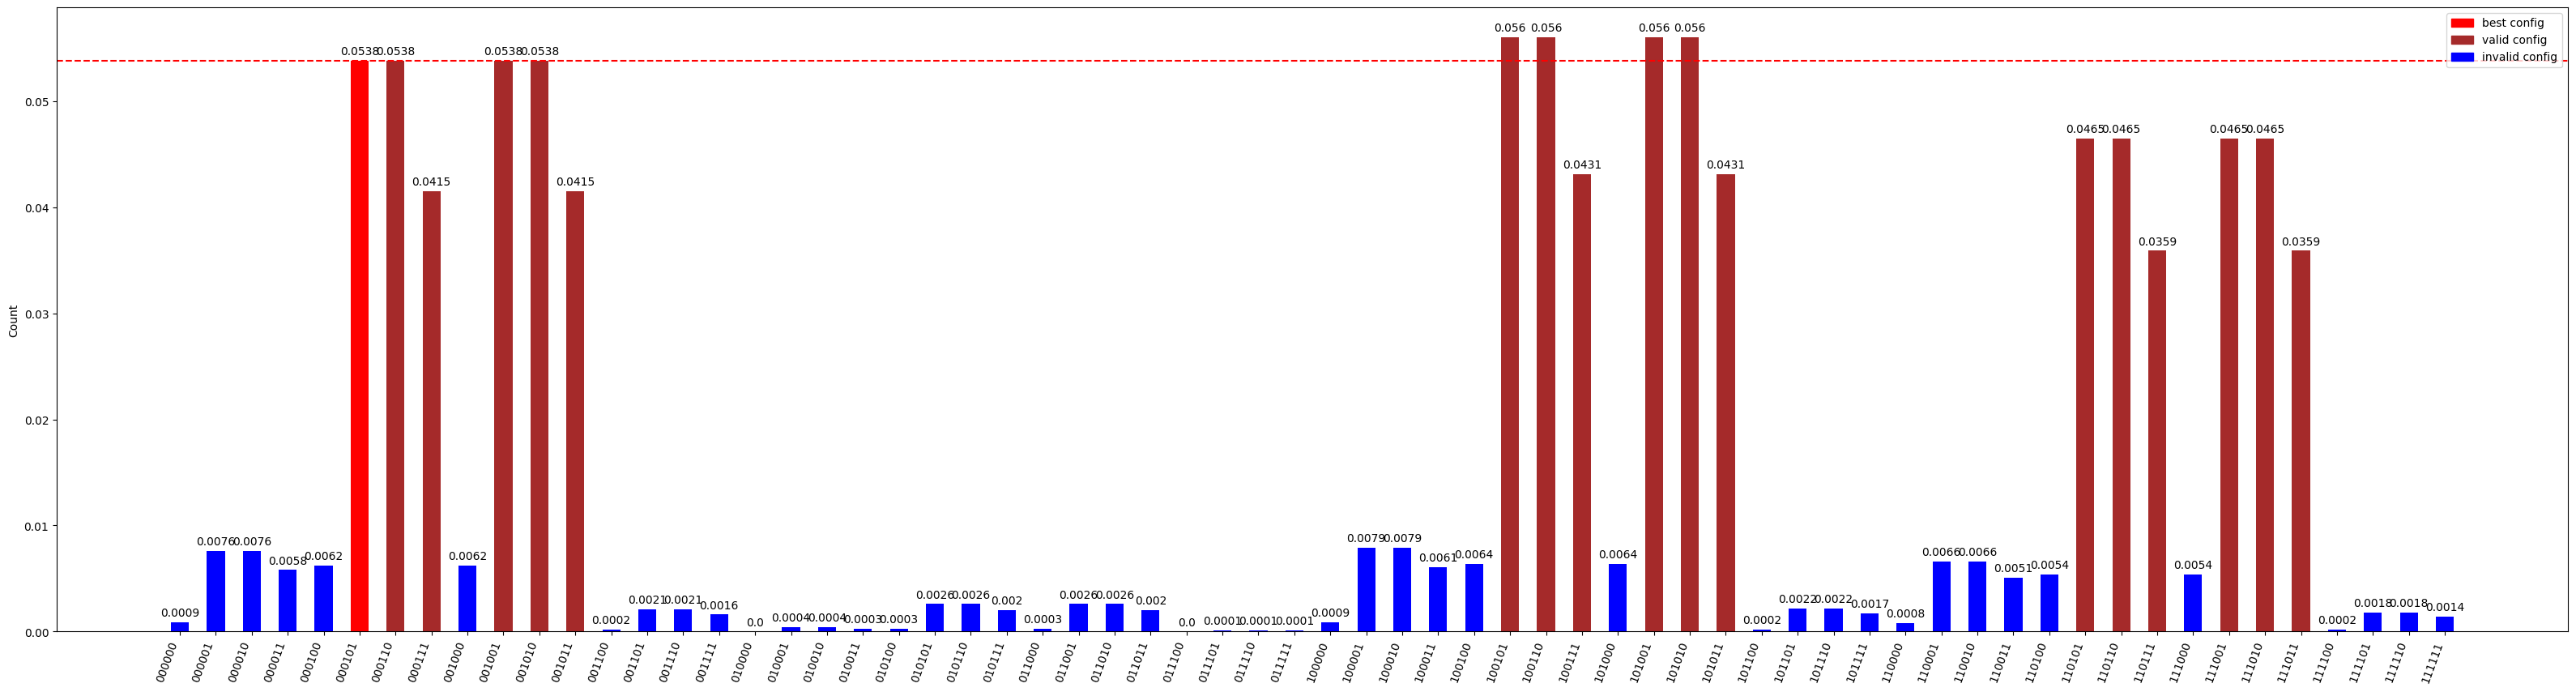

In [8]:
# plot quadratized QUBO results
probabilities_dict_list = []
if run_quso_qaoa:
    for index, instance in enumerate(problem_instances):
        print(f"Instance {index}:")
        hamiltonian = instance.get_quso_combined_hamiltonian()

        probabilities, _ = apply_qaoa_statevector(quso_problem_circuit, hamiltonian, layers, get_hamiltonian_dimension(hamiltonian), theta, warmstart_statevector, strategy=strategy, use_optimizer=use_optimizer, print_res=print_res)
        probabilities_dict = {}
        for i in range(0, 2 ** get_hamiltonian_dimension(hamiltonian)):
            probabilities_dict[np.binary_repr(i, width=get_hamiltonian_dimension(hamiltonian))] = probabilities[i]

        probabilities_dict = convert_ancilla_bit_results(probabilities_dict, instance.get_num_features())
        probabilities_dict_list.append(probabilities_dict)

        for key in probabilities_dict:
            probabilities_dict[key] = round(probabilities_dict[key], 4)

        plot_counts_histogram(probabilities_dict, instance.get_num_features(), instance.get_best_config(), instance.get_valid_configs())

In [9]:
# rank instances by result_quality = success_probability * 2^num_features / num_valid_configs
if run_quso_qaoa:
    result_quality_list = []
    for index, instance in enumerate(problem_instances):
        if len(instance.get_valid_configs()) == 0:
            continue
        # determine result quality
        probabilities_dict = probabilities_dict_list[index]
        result_quality = 0
        for config in instance.get_valid_configs():
            result_quality += probabilities_dict[config]
        result_quality *= 2 ** instance.get_num_features() / len(instance.get_valid_configs())
        result_quality_list.append(result_quality)

    # sort instances by result_quality
    sorted_indices = np.argsort(result_quality_list)
    sorted_indices = sorted_indices[::-1]
    sorted_problem_instances = [problem_instances[i] for i in sorted_indices]
    success_probabilities_per_valid_config_list = [result_quality_list[i] for i in sorted_indices]
    for index, instance in enumerate(sorted_problem_instances):
        print(f"Instance {sorted_indices[index]}:")
        print(str(instance))
        print(f"Result quality: {result_quality_list[sorted_indices[index]]}")

Instance 0:
sat_instance: (\neg x1 \vee \neg x2) \wedge (x3 \vee x4) \wedge (\neg x3 \vee \neg x4) \wedge (x5 \vee \neg x6)
n_features: 6
feature_cost: [100, 100, 100, 100, 100, 10]
alpha_sat: 765.0
Result quality: 3.079822222222223
